# DNN 实现 逻辑回归

## 1. 生成一个用于逻辑回归测试的数据

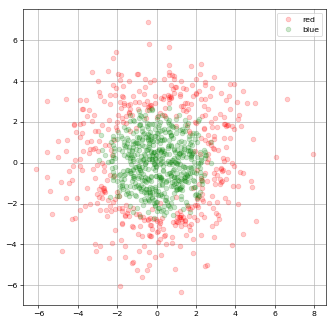

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def tf_data(m=1000):
#   np.random.seed(const_number)  保证每次输出结果不变。
    np.random.seed(1)
    X = 2*np.random.randn(2,m)
#   很方便的求 2-范数 的方法（相当于求半径）
    R = np.linalg.norm(X,ord=2,axis=0).reshape(1,m)
    np.random.seed(2)
#   增加一个噪音
    noise = .3 * np.random.normal(size=R.shape)
    R = R + noise
#   二值化输出
    Y = np.int32(np.array(R < 2.5))
#   合并输入输出数据 （学会用 np.r_[...] 和 np.c_[...])
    X = np.r_[X,Y]
    return X

def plot_tf(tf,alpha=0.2):
    f = tf[:,tf[-1,:]==0]
    t = tf[:,tf[-1,:]==1]
    
    plt.figure(figsize=(7,7),dpi=56)
    plt.grid(True)
    plt.plot(f[0], f[1], 'ro', alpha=alpha, label='red')
    plt.plot(t[0], t[1], 'go', alpha=alpha, label='blue')
    plt.legend()
    plt.show()
    
tf = tf_data()
plot_tf(tf)
X = tf[:-1]
Y = tf[-1:]

## 2. 为 DNN 准备好逻辑回归用得着的  代价函数、激活函数、高级字典 Ea

In [2]:
# 高级字典 Ea
from collections import defaultdict
class Ea(defaultdict):
    def __setattr__(self, name, value):
        super(Ea, self).__setitem__(name, value)
        
def L2(A, Y):
    loss = 1/2 * np.dot((A-Y), (A-Y).T)
    loss = np.squeeze(loss)
    return loss

def dL2(A,Y):
    return A-Y

def L3(A, Y):
    m = Y.shape[1]
    loss = -1 / m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A), axis=1, keepdims=True)
    loss = np.squeeze(loss)
    assert (loss.shape == ())
    return loss

def dL3(A,Y):
    loss = -Y/A + (1-Y)/(1-A)
    loss = np.squeeze(loss)
    return loss

def relu(z):
    g = np.fmax(z, 0)
    return g

def dz_relu(z):
    g = np.fmax(z,0)
    g = np.sign(g)
    return g

def leaky_relu(z):
    g = np.fmax(z, 0.01*z)
    return g

def dz_leaky_relu(z):
    g = np.piecewise(z, [z < 0, z > 0], [.01, 1])
    return g

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

def dz_sigmoid(z):
    s = sigmoid(z)
    dz = s * (1-s)
    return dz

## 3. 实现DNN初始化参数和迭代方法

In [3]:
# DNN 网络 随机初始化 W, b
def dnn_init_wb(L, n):
    W = Ea()
    b = Ea()
    p = 0.2
    for l in range(1, L + 1):
        np.random.seed(2)
        W[l] = np.random.normal(size=(n[l], n[l - 1])) * p
        b[l] = np.zeros(shape=(n[l], 1))
    return W,b

# DNN 网络 根据网络模型，预测结果
def dnn_predict(L,W,b,X):
    A=Ea()
    A[0]=X
    Z=Ea()
    
    for l in range(1, L + 1):
        Z[l] = np.dot(W[l], A[l - 1]) + b[l]
        A[l] = g[l](Z[l])
    yhat = A[L]
    return yhat
    

# DNN 网络 迭代
def dnn_run(X,Y,L,W,b,g,dg,J,dJ,learn_rate=0.02,max_itr=5000,tg=0.0001):
    # max_itr: 最大迭代次数
    # tg: 梯度截断参数
    output_cost = []

    A=Ea()
    A[0]=X
    dA = Ea()
    dZ = Ea()
    dW = Ea()
    db = Ea()
    Z=Ea()

    break_flag = 0
    old_cost = 0

    for i in range(1, max_itr):
        # forward properation
        for l in range(1, L + 1):
            Z[l] = np.dot(W[l], A[l - 1]) + b[l]
            A[l] = g[l](Z[l])

        cost = J(A[L], Y)
        # print(cost)
        dA[L] = dJ(A[L], Y)
        output_cost.append(cost)
        if old_cost - cost < tg * output_cost[0]:
            break_flag += 1

        old_cost = cost

        # back properation
        for l in range(0, L):
            l = L - l
            _dg = dg[l](Z[l])
            dZ[l] = _dg * dA[l]
            dA[l - 1] = np.dot(W[l].T, dZ[l])
            dW[l] = 1 / X.shape[1] * np.dot(dZ[l], A[l - 1].T)
            db[l] = 1 / X.shape[1] * np.sum(dZ[l], axis=1, keepdims=True)

        # update parameters
        for l in range(0, L):
            l = L - l
            W[l] = W[l] - learn_rate * dW[l]
            b[l] = b[l] - learn_rate * db[l]

        if break_flag > 30:
            break

    return np.squeeze(output_cost)

## 3. 初始化超级参数

In [4]:
L=2 # 或 L=3 试试
n=[0,20,4,1] # 定义每层神经节点个数
n[0] = X.shape[0]
n[L] = 1 # 前置输出层一个节点

g = Ea() # 定义激活函数
g[1] = relu
g[2] = relu
g[L] = sigmoid

dg = Ea() # 定义激活导函数
dg[1] = dz_relu
dg[2] = dz_relu
dg[L] = dz_sigmoid

J = L3 #定义 代价函数 (试试 L2)
dJ = dL3 #定义 代价导函数 (试试 dL2)

## 4. DNN 跑数据，训练模型

In [5]:
# 随机初始化 DNN Wb 参数
W, b = dnn_init_wb(L, n)
# DNN 训练模型
costs = dnn_run(X, Y, L, W, b, g, dg, J, dJ, 0.1, max_itr=100000, tg=0.00001)
# 注意：学习率要设高一些，否则学习会非常的慢
# 输出模型最终 代价值
print(costs[-1])

0.152754771297


## 5. 检查错误率

In [6]:
Yhat = dnn_predict(L,W,b,X)
Yhat = np.array(Yhat > 0.5)
Y = np.array(Y > 0.5)
result = np.int32(Y^Yhat)

print("判断错误的数据有%d条，占总数据的 %.2f%%" % (np.sum(result), 100*np.sum(result)/X.shape[1]))

判断错误的数据有59条，占总数据的 5.90%


## 6. 绘制逻辑回归损失函数

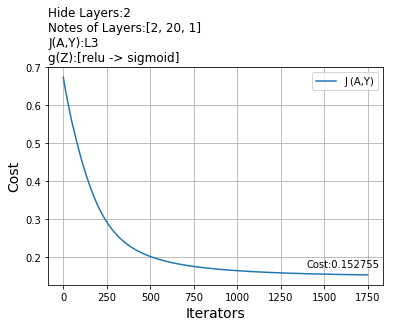

In [7]:
g_names = []
dg_names = []
for l in range(1,L+1):
    g_names.append(g[l].__name__)
    dg_names.append(dg[l].__name__)
    
plt.title("Hide Layers:%d \n" \
          "Notes of Layers:[%s] \n" \
          "J(A,Y):%s \n" \
          "g(Z):[%s]" % (L,
                         ", ".join(map(str,n[0:L+1])),
                         J.__name__,
                         " -> ".join(g_names)),loc='left')
plt.grid(True)
wd = len(costs)
plt.plot(range(0, len(costs)), costs, label='J (A,Y)')
plt.ylabel("Cost", fontsize=14)
plt.xlabel("Iterators", fontsize=14)
plt.text(wd * .8, (costs[0]-costs[-1]) * .33, "Cost:%f" % costs[-1])
plt.legend()
plt.show()